<a href="https://colab.research.google.com/github/safeai-snu/Econometrics/blob/main/Ch3.4.ARIMA_errors.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

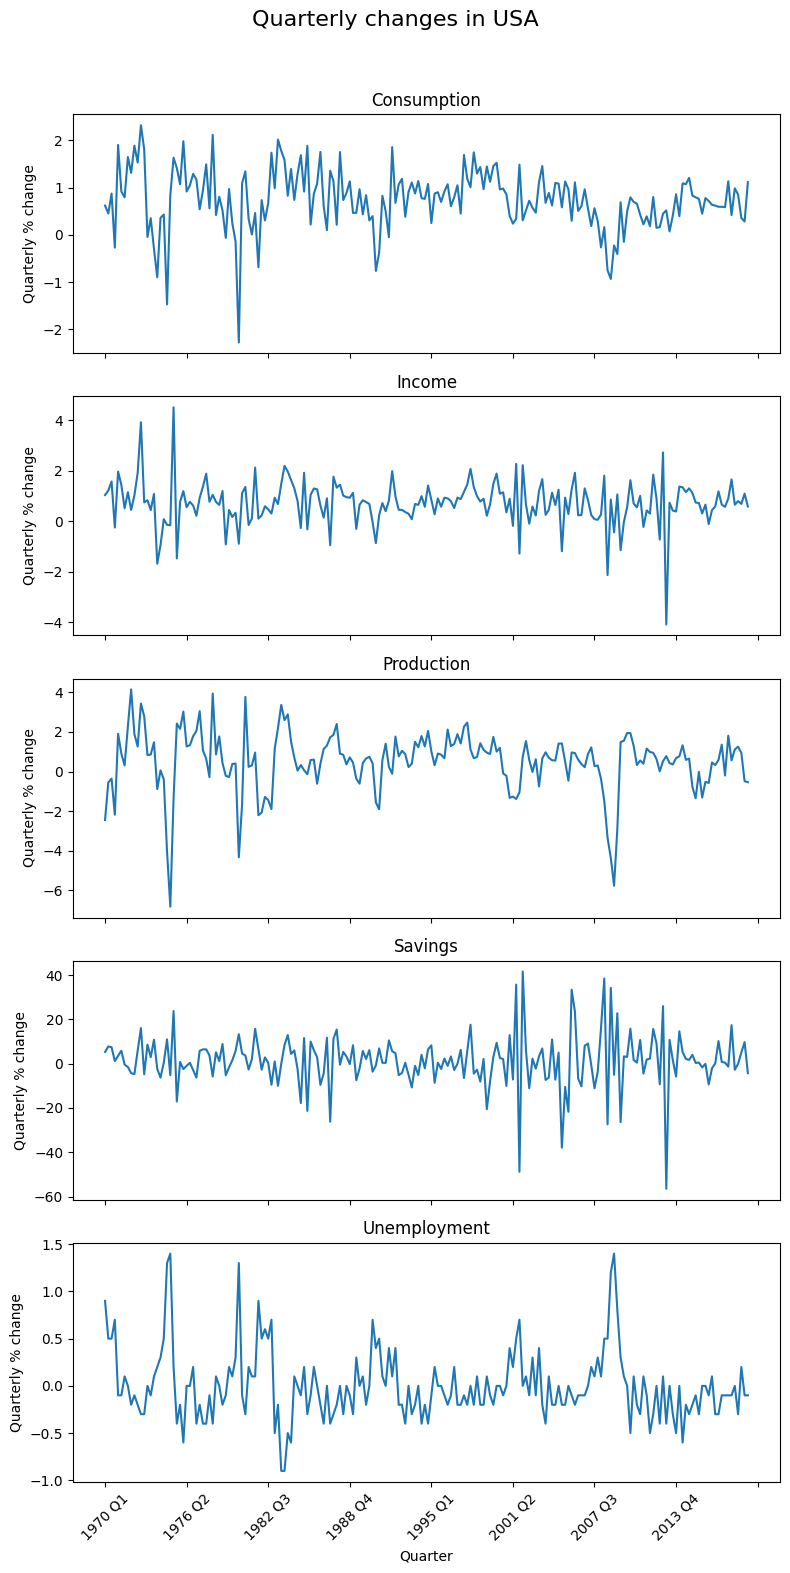

In [3]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# us_change = pd.read_csv("dataset/Ch.3/us_change.csv")
us_change = pd.read_csv("sample_data/us_change.csv")

variables = ["Consumption", "Income", "Production", "Savings", "Unemployment"]

fig, axes = plt.subplots(len(variables), 1, figsize=(8, 16), sharex=True)

for i, var in enumerate(variables):
    sns.lineplot(x='Quarter', y=var, data=us_change, ax=axes[i])
    axes[i].set_ylabel("Quarterly % change")
    axes[i].set_title(var)

    axes[i].tick_params(axis='x', rotation=45)

    axes[i].xaxis.set_major_locator(plt.MaxNLocator(10))

plt.suptitle("Quarterly changes in USA", fontsize=16)

plt.tight_layout(rect=[0, 0, 1, 0.96])

plt.show()


In [4]:
import pandas as pd
import statsmodels.api as sm

y = us_change['Consumption']
X = us_change['Income']

X = sm.add_constant(X)

model = sm.tsa.SARIMAX(y, exog=X, order=(1, 0, 2))
fitted = model.fit(disp=False)

print(fitted.summary())

ar1 = fitted.params['ar.L1']
ma1 = fitted.params['ma.L1']
ma2 = fitted.params['ma.L2']
income_coef = fitted.params['Income']
intercept = fitted.params['const']

print(f"AR(1) coefficient: {ar1}")
print(f"MA(1) coefficient: {ma1}")
print(f"MA(2) coefficient: {ma2}")
print(f"Income coefficient: {income_coef}")
print(f"Intercept: {intercept}")

                               SARIMAX Results                                
Dep. Variable:            Consumption   No. Observations:                  198
Model:               SARIMAX(1, 0, 2)   Log Likelihood                -163.036
Date:                Thu, 12 Sep 2024   AIC                            338.072
Time:                        10:48:29   BIC                            357.802
Sample:                             0   HQIC                           346.058
                                - 198                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.5949      0.085      7.028      0.000       0.429       0.761
Income         0.1976      0.034      5.855      0.000       0.131       0.264
ar.L1          0.7070      0.106      6.657      0.0

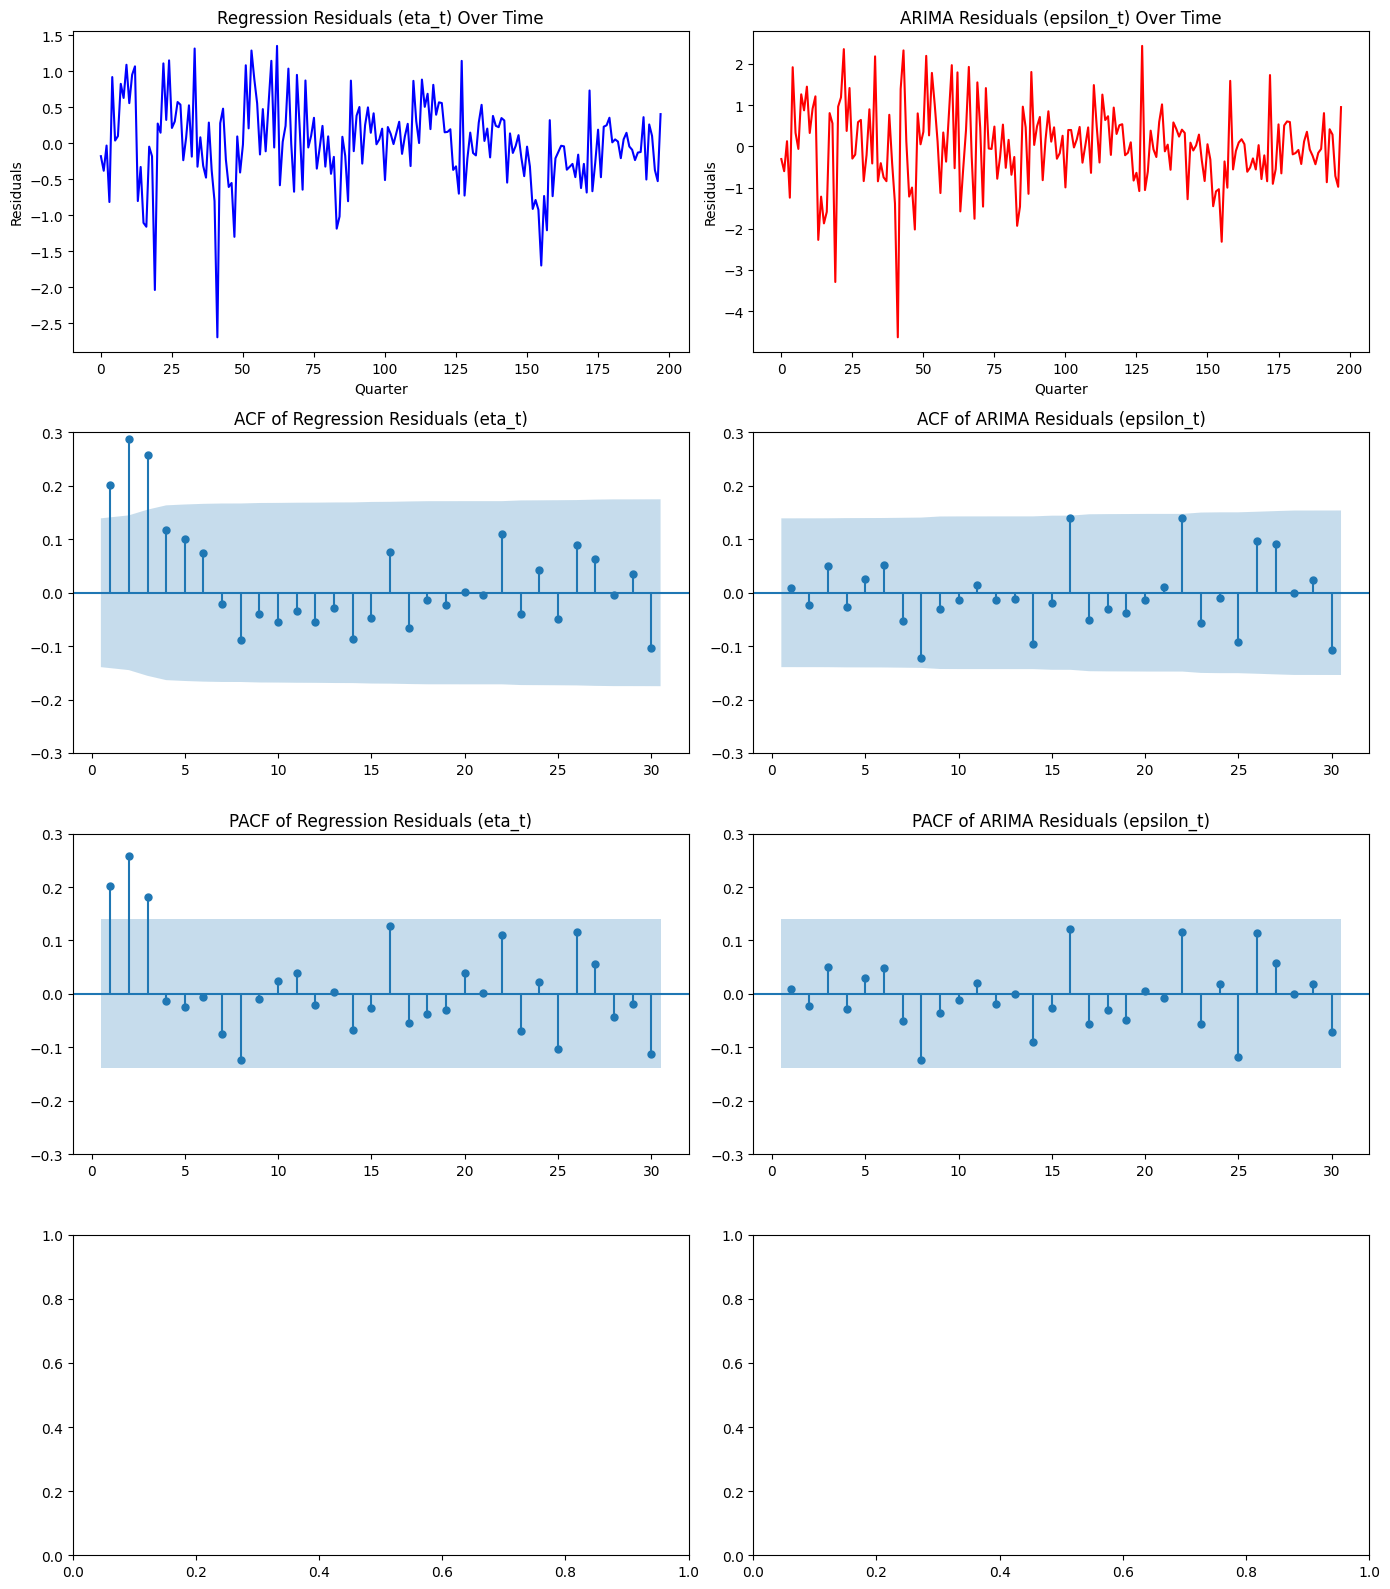

In [5]:
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns

regression_residuals = y - X['Income']*income_coef - X['const']*intercept

arima_residuals = fitted.filter_results.standardized_forecasts_error[0]

fig, ax = plt.subplots(4, 2, figsize=(14, 16))

ax[0, 0].plot(us_change.index, regression_residuals, label='Regression Residuals', color='blue')
ax[0, 0].set_title('Regression Residuals (eta_t) Over Time')
ax[0, 0].set_xlabel('Quarter')
ax[0, 0].set_ylabel('Residuals')

sm.graphics.tsa.plot_acf(regression_residuals, lags=30, ax=ax[1, 0], zero=False)
ax[1, 0].set_title('ACF of Regression Residuals (eta_t)')
ax[1, 0].set_ylim(-0.3,0.3)

sm.graphics.tsa.plot_pacf(regression_residuals, lags=30, ax=ax[2, 0], zero=False)
ax[2, 0].set_title('PACF of Regression Residuals (eta_t)')
ax[2, 0].set_ylim(bottom=min(regression_residuals.min(), -1), top=max(regression_residuals.max(), 1))
ax[2, 0].set_ylim(-0.3,0.3)

ax[0, 1].plot(us_change.index, arima_residuals, label='ARIMA Residuals', color='red')
ax[0, 1].set_title('ARIMA Residuals (epsilon_t) Over Time')
ax[0, 1].set_xlabel('Quarter')
ax[0, 1].set_ylabel('Residuals')

sm.graphics.tsa.plot_acf(arima_residuals, lags=30, ax=ax[1, 1], zero=False)
ax[1, 1].set_title('ACF of ARIMA Residuals (epsilon_t)')
ax[1, 1].set_ylim(-0.3,0.3)

sm.graphics.tsa.plot_pacf(arima_residuals, lags=30, ax=ax[2, 1], zero=False)
ax[2, 1].set_title('PACF of ARIMA Residuals (epsilon_t)')
ax[2, 1].set_ylim(bottom=min(arima_residuals.min(), -1), top=max(arima_residuals.max(), 1))
ax[2, 1].set_ylim(-0.3,0.3)

plt.tight_layout()
plt.show()


In [6]:
def show_forecast(series, fitted, horizon, x, y, title):
    forecast = fitted.get_forecast(horizon).predicted_mean
    ci = fitted.get_forecast(horizon)
    lower_ci80 = ci.conf_int(alpha=0.2).iloc[:,0]
    upper_ci80 = ci.conf_int(alpha=0.2).iloc[:,1]
    lower_ci95 = ci.conf_int(alpha=0.05).iloc[:,0]
    upper_ci95 = ci.conf_int(alpha=0.05).iloc[:,1]

    plt.figure(figsize=(10, 6))
    plt.plot(series, label='Observation', color='black')
    plt.plot(forecast, label='forecast', color='b')
    plt.fill_between(forecast.index, lower_ci80, upper_ci80, label='80', color='b', alpha=.2)
    plt.fill_between(forecast.index, lower_ci95, upper_ci95, label='95', color='b', alpha=.1)
    plt.xlabel(x)
    plt.ylabel(y)
    plt.title(title)
    plt.grid(True)
    plt.legend()
    plt.show()

Original exog shape: (198, 2)
Future exog shape: (8, 2)


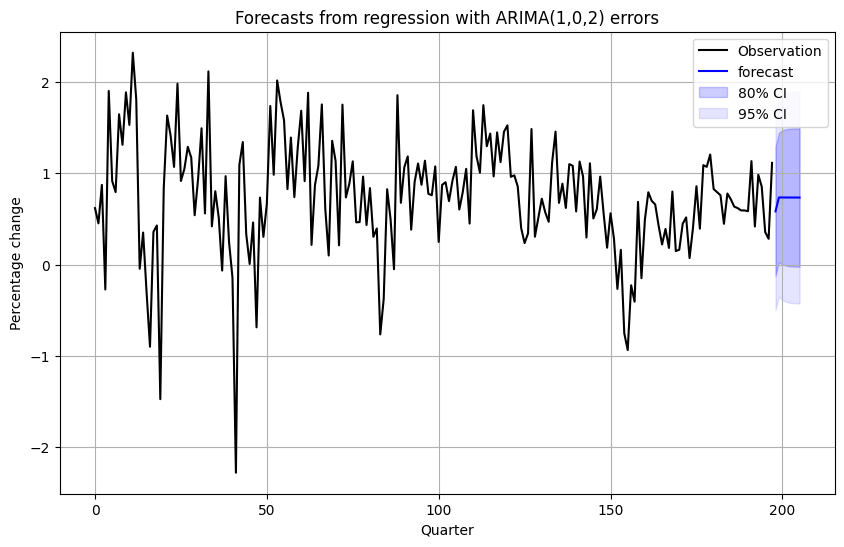

In [8]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
from statsmodels.tsa.statespace.sarimax import SARIMAX
import matplotlib.pyplot as plt

# Assuming 'us_change' is your existing dataframe
us_change = pd.read_csv("sample_data/us_change.csv")

# Define the endogenous and exogenous variables
y = us_change['Consumption']
X = us_change['Income']

# Step 1: Add constant to exogenous variables in the original dataset
X = sm.add_constant(X)

# Step 2: Fit the SARIMAX model
model = SARIMAX(y, exog=X, order=(1, 0, 2))
fitted = model.fit(disp=False)

# Step 3: Calculate the mean percentage change in Income over the last 40 years (40*4=160 quarters)
mean_income_change = us_change['Income'].tail(160).mean()

# Step 4: Convert the "Quarter" column to a pandas Period object for date handling
us_change['Year'] = us_change['Quarter'].str[:4].astype(int)
us_change['Qtr'] = us_change['Quarter'].str[-2:]

# Map "Q1", "Q2", etc., to month numbers and create a datetime column
quarter_to_month = {"Q1": "01", "Q2": "04", "Q3": "07", "Q4": "10"}
us_change['Month'] = us_change['Qtr'].map(quarter_to_month)
us_change['Date'] = pd.to_datetime(us_change[['Year', 'Month']].assign(DAY=1))

# Convert the datetime to a PeriodIndex
us_change['Quarter'] = us_change['Date'].dt.to_period('Q')

# Step 5: Generate future dates based on the last available quarter
last_period = us_change['Quarter'].iloc[-1]
future_periods = [last_period + i for i in range(1, 9)]

# Create a new dataframe for the future eight quarters
us_change_future = pd.DataFrame({
    'Quarter': future_periods,
    'Income': np.repeat(mean_income_change, 8)  # Use the mean income change
})

# Step 6: Add constant to future exogenous variables (same as was done for the training data)
# Ensure that the constant is properly included in the future exog data
us_change_future_exog = sm.add_constant(us_change_future[['Income']], has_constant='add')

# Print shapes to confirm
print("Original exog shape:", X.shape)
print("Future exog shape:", us_change_future_exog.shape)

# Step 7: Forecast the next eight quarters using the fitted model
forecast = fitted.get_forecast(steps=8, exog=us_change_future_exog).predicted_mean
us_change_future['Consumption'] = forecast.values

# Combine the original data and the forecast data for plotting
us_change_full = pd.concat([us_change.set_index('Quarter'), us_change_future.set_index('Quarter')])

# Step 9: Function to visualize the forecast
def show_forecast(series, fitted, horizon, x, y, title):
    forecast = fitted.get_forecast(horizon, exog=us_change_future_exog).predicted_mean
    ci = fitted.get_forecast(horizon, exog=us_change_future_exog)
    lower_ci80 = ci.conf_int(alpha=0.2).iloc[:, 0]
    upper_ci80 = ci.conf_int(alpha=0.2).iloc[:, 1]
    lower_ci95 = ci.conf_int(alpha=0.05).iloc[:, 0]
    upper_ci95 = ci.conf_int(alpha=0.05).iloc[:, 1]

    plt.figure(figsize=(10, 6))
    plt.plot(series, label='Observation', color='black')
    plt.plot(forecast, label='forecast', color='b')
    plt.fill_between(forecast.index, lower_ci80, upper_ci80, label='80% CI', color='b', alpha=.2)
    plt.fill_between(forecast.index, lower_ci95, upper_ci95, label='95% CI', color='b', alpha=.1)
    plt.xlabel(x)
    plt.ylabel(y)
    plt.title(title)
    plt.grid(True)
    plt.legend()
    plt.show()

# Step 10: Visualize the forecast
show_forecast(
    series=us_change['Consumption'],
    fitted=fitted,
    horizon=8,
    x='Quarter',
    y='Percentage change',
    title='Forecasts from regression with ARIMA(1,0,2) errors'
)


Electricity demand

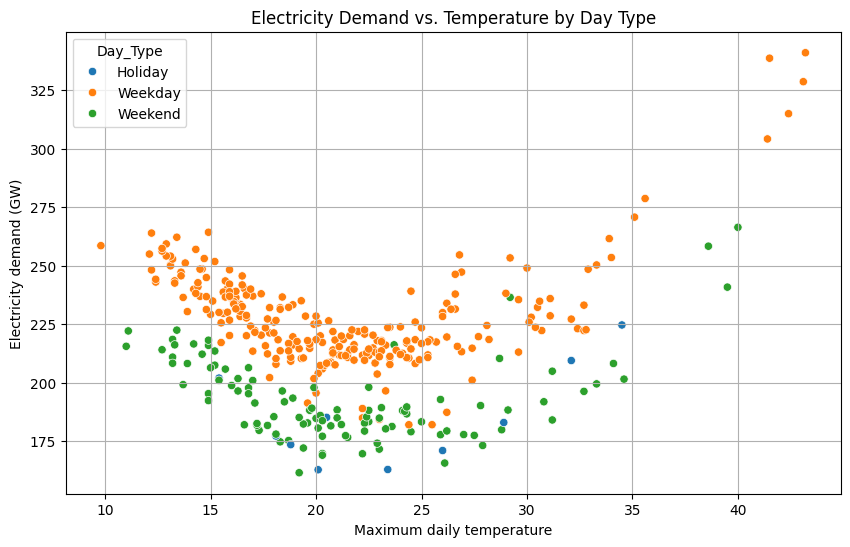

In [9]:
import numpy as np

vic_elec = pd.read_csv("sample_data/vic_elec.csv")
# Step 1: Data Manipulation

# Convert 'Time' to datetime, handling inconsistencies
vic_elec['Time'] = pd.to_datetime(vic_elec['Time'], format='%Y-%m-%d %H:%M:%S', errors='coerce')

# Extract just the date component
vic_elec['Date'] = vic_elec['Time'].dt.date

# Filter for the year 2014
vic_elec_2014 = vic_elec[pd.to_datetime(vic_elec['Date']).dt.year == 2014]

# Aggregate data by date
vic_elec_daily = vic_elec_2014.groupby('Date').agg({
    'Demand': lambda x: x.sum() / 1e3,  # Sum the demand and convert to GW
    'Temperature': 'max',  # Get the max temperature
    'Holiday': 'any'  # Check if any of the days are holidays
}).reset_index()

# Determine the type of day
vic_elec_daily['Day_Type'] = np.where(
    vic_elec_daily['Holiday'], 'Holiday',
    np.where(pd.to_datetime(vic_elec_daily['Date']).dt.weekday.isin([0, 1, 2, 3, 4]), 'Weekday', 'Weekend')
)

# Step 2: Plotting

# Initialize the plot
plt.figure(figsize=(10, 6))
sns.scatterplot(data=vic_elec_daily, x='Temperature', y='Demand', hue='Day_Type')

# Add labels and title
plt.xlabel('Maximum daily temperature')
plt.ylabel('Electricity demand (GW)')
plt.title('Electricity Demand vs. Temperature by Day Type')

# Display the plot
plt.grid(True)
plt.show()


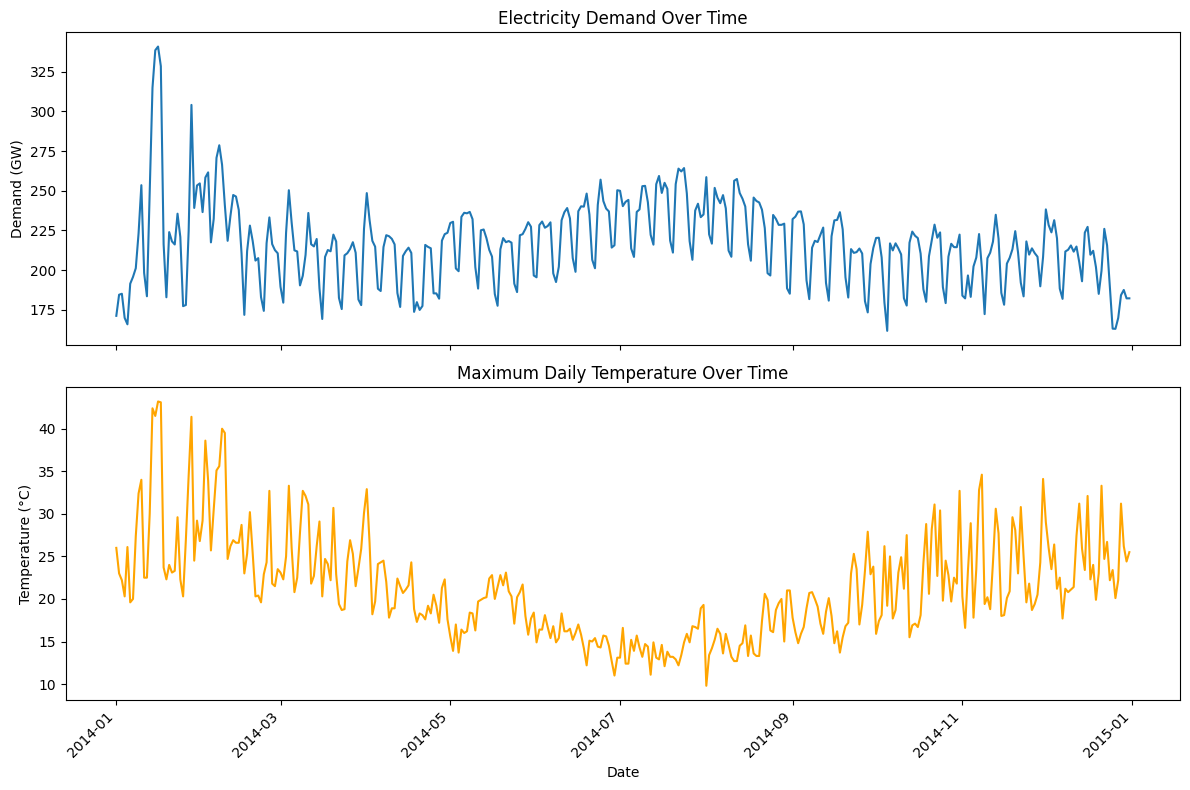

In [16]:
# Assuming vic_elec_daily is your DataFrame after the previous manipulation

# Step 1: Pivot the data to a long format
vic_elec_long = pd.melt(vic_elec_daily, id_vars=['Date'], value_vars=['Demand', 'Temperature'],
                        var_name='name', value_name='value')

# Step 2: Plotting without FacetGrid

# Create a figure and axes
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8), sharex=True)

# Plot Demand
ax1.plot(vic_elec_long[vic_elec_long['name'] == 'Demand']['Date'],
         vic_elec_long[vic_elec_long['name'] == 'Demand']['value'], label='Demand')
ax1.set_ylabel('Demand (GW)')
ax1.set_title('Electricity Demand Over Time')

# Plot Temperature
ax2.plot(vic_elec_long[vic_elec_long['name'] == 'Temperature']['Date'],
         vic_elec_long[vic_elec_long['name'] == 'Temperature']['value'], label='Temperature', color='orange')
ax2.set_ylabel('Temperature (°C)')
ax2.set_title('Maximum Daily Temperature Over Time')

# Common x-axis label
ax2.set_xlabel('Date')

# Rotate x-axis labels for better readability
plt.setp(ax2.get_xticklabels(), rotation=45, ha='right')

# Adjust layout to prevent overlap
plt.tight_layout()

# Show the plot
plt.show()

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                               SARIMAX Results                                
Dep. Variable:             log_Demand   No. Observations:                  365
Model:                 ARIMA(2, 0, 0)   Log Likelihood                 644.356
Date:                Thu, 12 Sep 2024   AIC                          -1274.712
Time:                        10:56:51   BIC                          -1247.413
Sample:                             0   HQIC                         -1263.863
                                - 365                                         
Covariance Type:                  opg                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             5.9503      0.029    203.745      0.000       5.893       6.008
Temperature      -0.0634      0.002    -28.874      0.000      -0.068      -0.059
Temperature^2     0.0013    3.9e-05     

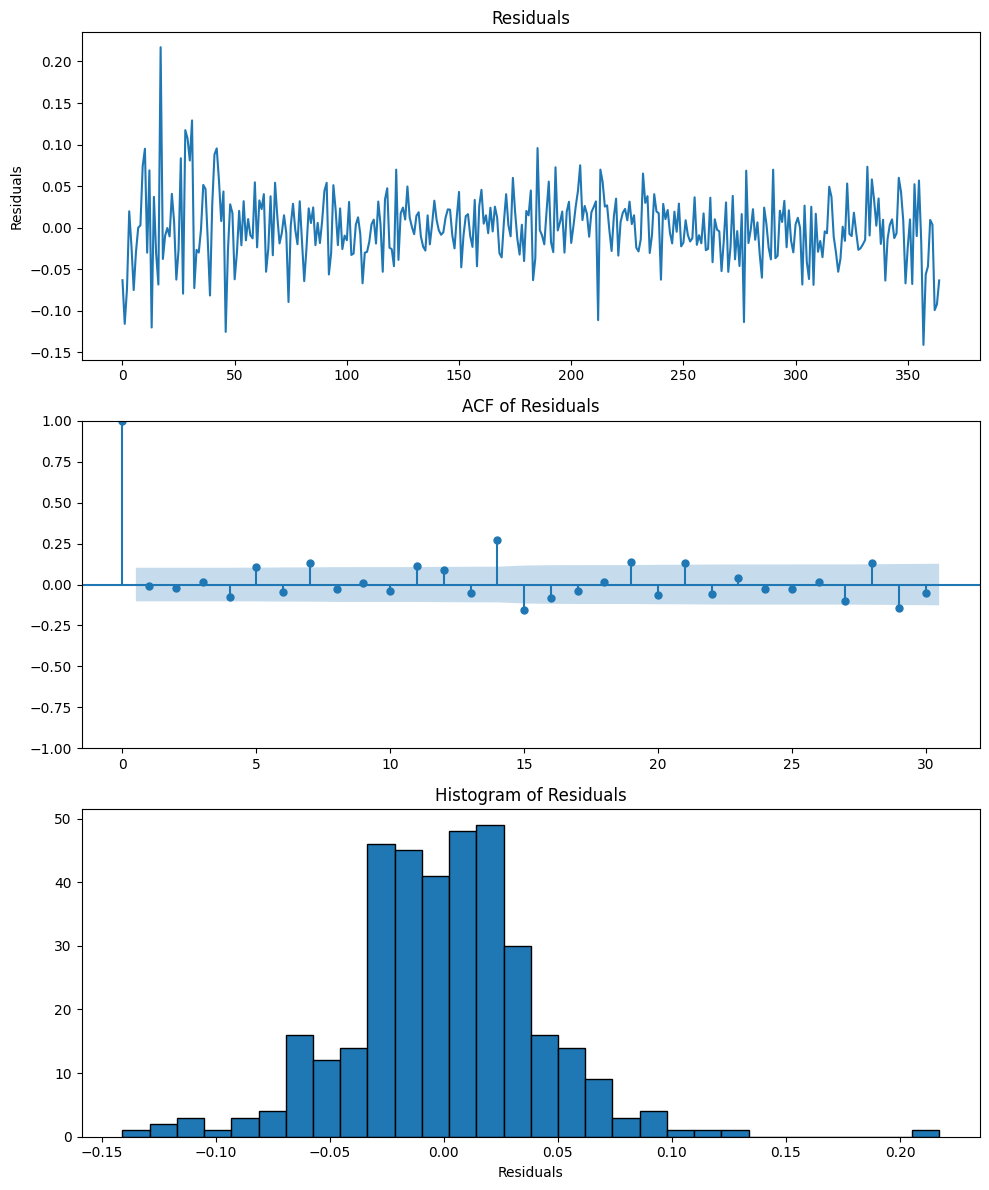

In [17]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt

# Step 1: Prepare the exogenous variables (Temperature, Temperature^2, Weekday)
vic_elec_daily['Weekday'] = (vic_elec_daily['Day_Type'] == 'Weekday').astype(int)
X = pd.DataFrame()
X['Temperature'] = vic_elec_daily['Temperature']
X['Temperature^2'] = vic_elec_daily['Temperature'] ** 2
X['Weekday'] = vic_elec_daily['Weekday']

# Step 2: Log transform the Demand
vic_elec_daily['log_Demand'] = np.log(vic_elec_daily['Demand'])

# Step 3: Fit the ARIMA model
# Specifying an ARIMA(2, 0, 0) model as an example; you'll need to adjust based on your data
model = sm.tsa.ARIMA(vic_elec_daily['log_Demand'], exog=X, order=(2, 0, 0))
# model = sm.tsa.SARIMAX(vic_elec_daily['log_Demand'], exog=X, order=(2, 0, 0))
fit = model.fit()

# Print the summary of the model
print(fit.summary())

# Step 4: Diagnostic Plots
# Extract residuals
residuals = fit.resid

# Plotting the residuals
fig, ax = plt.subplots(3, 1, figsize=(10, 12))

# Residual plot
ax[0].plot(residuals)
ax[0].set_title('Residuals')
ax[0].set_ylabel('Residuals')

# ACF plot of residuals
sm.graphics.tsa.plot_acf(residuals, ax=ax[1], lags=30)
ax[1].set_title('ACF of Residuals')

# Histogram of residuals
ax[2].hist(residuals, bins=30, edgecolor='black')
ax[2].set_title('Histogram of Residuals')
ax[2].set_xlabel('Residuals')

# Adjust layout to prevent overlap
plt.tight_layout()

# Show the plots
plt.show()


<ipython-input-18-4cca1552f936>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['Temperature^2'] = vic_elec_daily['Temperature'] ** 2
<ipython-input-18-4cca1552f936>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['Weekday'] = vic_elec_daily['Weekday']
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                               SARIMAX Results                                
Dep. Variable:                 Demand   No. Observations:                  365
Model:                 ARIMA(2, 0, 0)   Log Likelihood               -1261.021
Date:                Thu, 12 Sep 2024   AIC                           2536.042
Time:                        10:57:03   BIC                           2563.342
Sample:                             0   HQIC                          2546.891
                                - 365                                         
Covariance Type:                  opg                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const           353.8788     87.449      4.047      0.000     182.481     525.277
Temperature      -7.8170      0.660    -11.845      0.000      -9.110      -6.523
Temperature^2     0.1829      0.012     

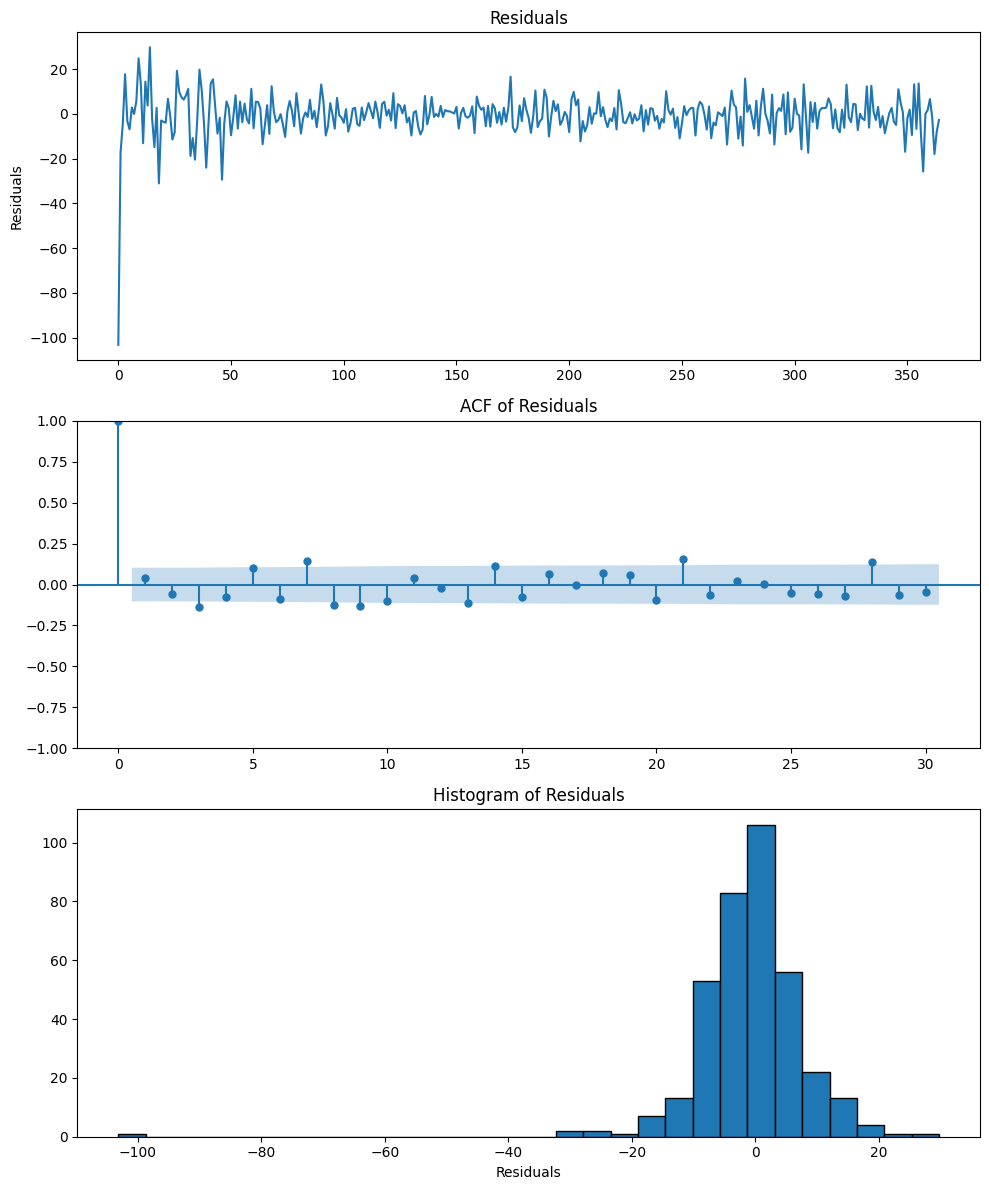

In [18]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import statsmodels.api as sm

vic_elec_daily['Weekday'] = (vic_elec_daily['Day_Type'] == 'Weekday').astype(int)

# Prepare the exogenous variables (Temperature, Temperature^2, Weekday)
X = vic_elec_daily[['Temperature']]
X['Temperature^2'] = vic_elec_daily['Temperature'] ** 2
X['Weekday'] = vic_elec_daily['Weekday']



# Step 2: Fit the ARIMA model
# We will use an ARIMA model with the exogenous variables
model = sm.tsa.ARIMA(vic_elec_daily['Demand'], exog=X, order=(2, 0, 0))
# model = sm.tsa.SARIMAX(vic_elec_daily['Demand'], exog=X, order=(2, 0, 0))

fit = model.fit()

print(fit.summary())
# Step 3: Plot the residuals
residuals = fit.resid

# Plotting the residuals
fig, ax = plt.subplots(3, 1, figsize=(10, 12))

# Residual plot
ax[0].plot(residuals)
ax[0].set_title('Residuals')
ax[0].set_ylabel('Residuals')

# ACF plot of residuals
sm.graphics.tsa.plot_acf(residuals, ax=ax[1], lags=30)
ax[1].set_title('ACF of Residuals')

# Histogram of residuals
ax[2].hist(residuals, bins=30, edgecolor='black')
ax[2].set_title('Histogram of Residuals')
ax[2].set_xlabel('Residuals')

# Adjust layout to prevent overlap
plt.tight_layout()

# Show the plots
plt.show()

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                               SARIMAX Results                                
Dep. Variable:                 Demand   No. Observations:                  365
Model:                 ARIMA(2, 0, 0)   Log Likelihood               -1261.021
Date:                Thu, 12 Sep 2024   AIC                           2536.042
Time:                        11:13:29   BIC                           2563.342
Sample:                             0   HQIC                          2546.891
                                - 365                                         
Covariance Type:                  opg                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const           353.8788     87.449      4.047      0.000     182.481     525.277
Temperature      -7.8170      0.660    -11.845      0.000      -9.110      -6.523
Temperature^2     0.1829      0.012     

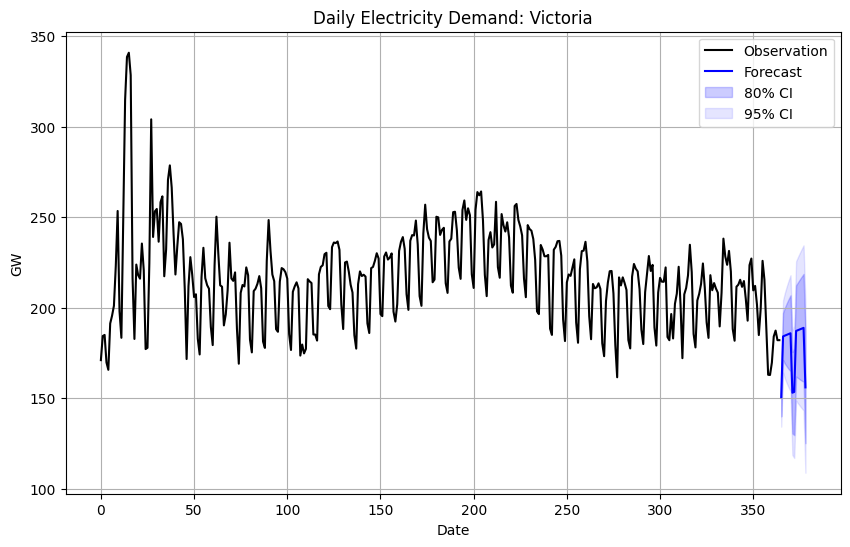

In [25]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt

# Assuming 'vic_elec_daily' is your existing dataframe
vic_elec_daily['Weekday'] = (vic_elec_daily['Day_Type'] == 'Weekday').astype(int)

# Prepare the exogenous variables
X = pd.DataFrame()
X['Temperature'] = vic_elec_daily['Temperature']
X['Temperature^2'] = vic_elec_daily['Temperature'] ** 2
X['Weekday'] = vic_elec_daily['Weekday']

# Log transform the Demand
vic_elec_daily['log_Demand'] = np.log(vic_elec_daily['Demand'])

# Step 1: Fit the ARIMA model with exogenous variables
model = sm.tsa.ARIMA(vic_elec_daily['Demand'], exog=X, order=(2, 0, 0))
fit = model.fit()

print(fit.summary())

# Step 2: Create future exogenous variables (for the next 14 days)
# You can either use a realistic assumption or repeat the last known values for simplicity

last_known_temperature = vic_elec_daily['Temperature'].iloc[-1]
last_known_weekday = vic_elec_daily['Weekday'].iloc[-1]

X_future = pd.DataFrame({
    'Temperature': np.repeat(26, 14),
    'Temperature^2': np.repeat(26**2, 14),
    'Weekday': [0] + [1] * 5 + [0] + [0] + [1] * 5 + [0]
})


# Step 3: Generate the forecast with exogenous variables
forecast_result = fit.get_forecast(steps=14, exog=X_future)

# Extract the forecasted mean and confidence intervals
forecast_mean = forecast_result.predicted_mean
lower_ci80 = forecast_result.conf_int(alpha=0.2).iloc[:, 0]
upper_ci80 = forecast_result.conf_int(alpha=0.2).iloc[:, 1]
lower_ci95 = forecast_result.conf_int(alpha=0.05).iloc[:, 0]
upper_ci95 = forecast_result.conf_int(alpha=0.05).iloc[:, 1]

# Step 4: Combine forecast with historical data
combined_series = pd.concat([vic_elec_daily['Demand'], forecast_mean])

# Step 5: Plotting the forecast with confidence intervals
plt.figure(figsize=(10, 6))
plt.plot(vic_elec_daily['Demand'], label='Observation', color='black')
plt.plot(forecast_mean, label='Forecast', color='b')
plt.fill_between(forecast_mean.index, lower_ci80, upper_ci80, label='80% CI', color='b', alpha=.2)
plt.fill_between(forecast_mean.index, lower_ci95, upper_ci95, label='95% CI', color='b', alpha=.1)
plt.xlabel('Date')
plt.ylabel('GW')
plt.title('Daily Electricity Demand: Victoria')
plt.grid(True)
plt.legend()
plt.show()


In [30]:
aus_airpassengers = pd.read_csv('sample_data/aus_airpassengers.csv', index_col=0)

In [31]:
aus_airpassengers

,Year,Passengers
csvbase_row_id,,
1,1970,7.318700
2,1971,7.326600
3,1972,7.795600
4,1973,9.384600
5,1974,10.664700
6,1975,11.055100
7,1976,10.864300
8,1977,11.306500
9,1978,12.122300


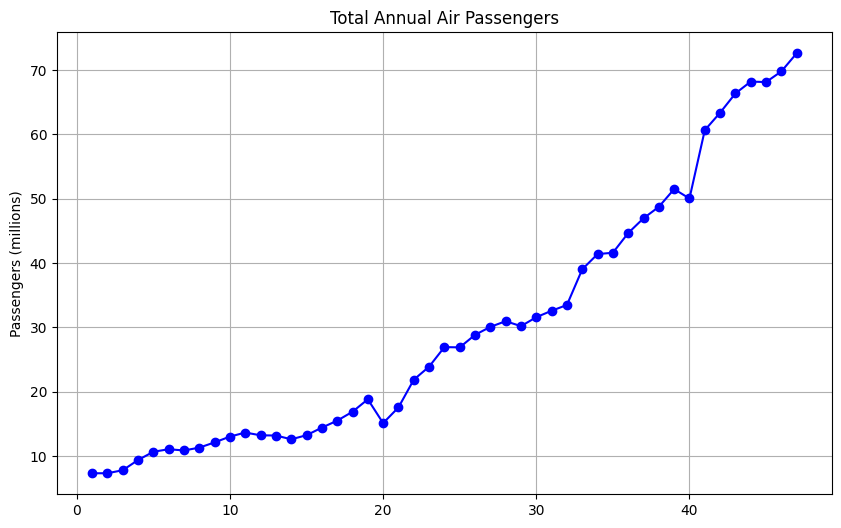

In [32]:
# Plotting the 'Passengers' column
plt.figure(figsize=(10, 6))
plt.plot(aus_airpassengers.index, aus_airpassengers['Passengers'], marker='o', linestyle='-', color='b')

# Adding labels and title
plt.ylabel('Passengers (millions)')
plt.title('Total Annual Air Passengers')
plt.grid(True)

# Show the plot
plt.show()


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dat

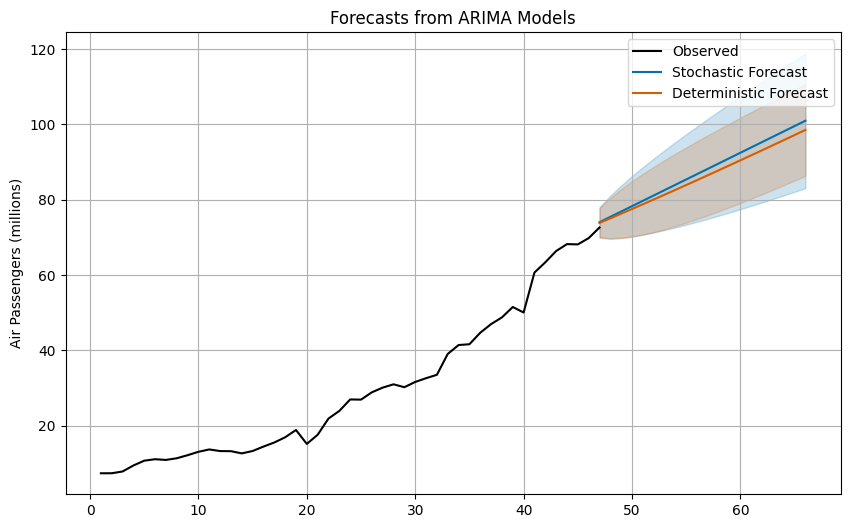

In [33]:
model_stochastic = sm.tsa.SARIMAX(aus_airpassengers['Passengers'], order=(0, 1, 0), trend='c')
fit_stochastic = model_stochastic.fit()

# Fit the deterministic ARIMA(1,0,0) model with a time trend
time_trend = np.arange(len(aus_airpassengers))
model_deterministic = sm.tsa.ARIMA(aus_airpassengers['Passengers'], exog=time_trend, order=(1, 0, 0), trend='n')
fit_deterministic = model_deterministic.fit()

# Forecast the next 20 periods for both models
forecast_stochastic = fit_stochastic.get_forecast(steps=20)
forecast_stochastic_mean = forecast_stochastic.predicted_mean
forecast_stochastic_ci = forecast_stochastic.conf_int(alpha=0.05)

future_trend = np.arange(len(aus_airpassengers), len(aus_airpassengers) + 20)
forecast_deterministic = fit_deterministic.get_forecast(steps=20, exog=future_trend)
forecast_deterministic_mean = forecast_deterministic.predicted_mean
forecast_deterministic_ci = forecast_deterministic.conf_int(alpha=0.05)

# Plot the historical data and forecasts
plt.figure(figsize=(10, 6))
plt.plot(aus_airpassengers.index, aus_airpassengers['Passengers'], label='Observed', color='black')

# Plot the stochastic model forecast
plt.plot(forecast_stochastic_mean.index, forecast_stochastic_mean, label='Stochastic Forecast', color='#0072B2')
plt.fill_between(forecast_stochastic_mean.index,
                 forecast_stochastic_ci.iloc[:, 0],
                 forecast_stochastic_ci.iloc[:, 1],
                 color='#0072B2', alpha=0.2)

# Plot the deterministic model forecast
plt.plot(forecast_deterministic_mean.index, forecast_deterministic_mean, label='Deterministic Forecast', color='#D55E00')
plt.fill_between(forecast_deterministic_mean.index,
                 forecast_deterministic_ci.iloc[:, 0],
                 forecast_deterministic_ci.iloc[:, 1],
                 color='#D55E00', alpha=0.2)

# Adding labels, title, and legend
plt.ylabel('Air Passengers (millions)')
plt.title('Forecasts from ARIMA Models')
plt.legend()
plt.grid(True)
plt.show()

In [41]:
aus_retail = pd.read_csv("sample_data/aus_retail.csv", index_col=0)
aus_retail

,State,Industry,Series ID,Month,Turnover
1,Australian Capital Territory,"Cafes, restaurants and catering services",A3349849A,1982 4,4.4
2,Australian Capital Territory,"Cafes, restaurants and catering services",A3349849A,1982 5,3.4
3,Australian Capital Territory,"Cafes, restaurants and catering services",A3349849A,1982 6,3.6
4,Australian Capital Territory,"Cafes, restaurants and catering services",A3349849A,1982 7,4.0
5,Australian Capital Territory,"Cafes, restaurants and catering services",A3349849A,1982 8,3.6
...,...,...,...,...,...
64528,Western Australia,Takeaway food services,A3349435A,2018 8,178.5
64529,Western Australia,Takeaway food services,A3349435A,2018 9,179.8
64530,Western Australia,Takeaway food services,A3349435A,2018 10,183.2
64531,Western Australia,Takeaway food services,A3349435A,2018 11,183.7


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Like

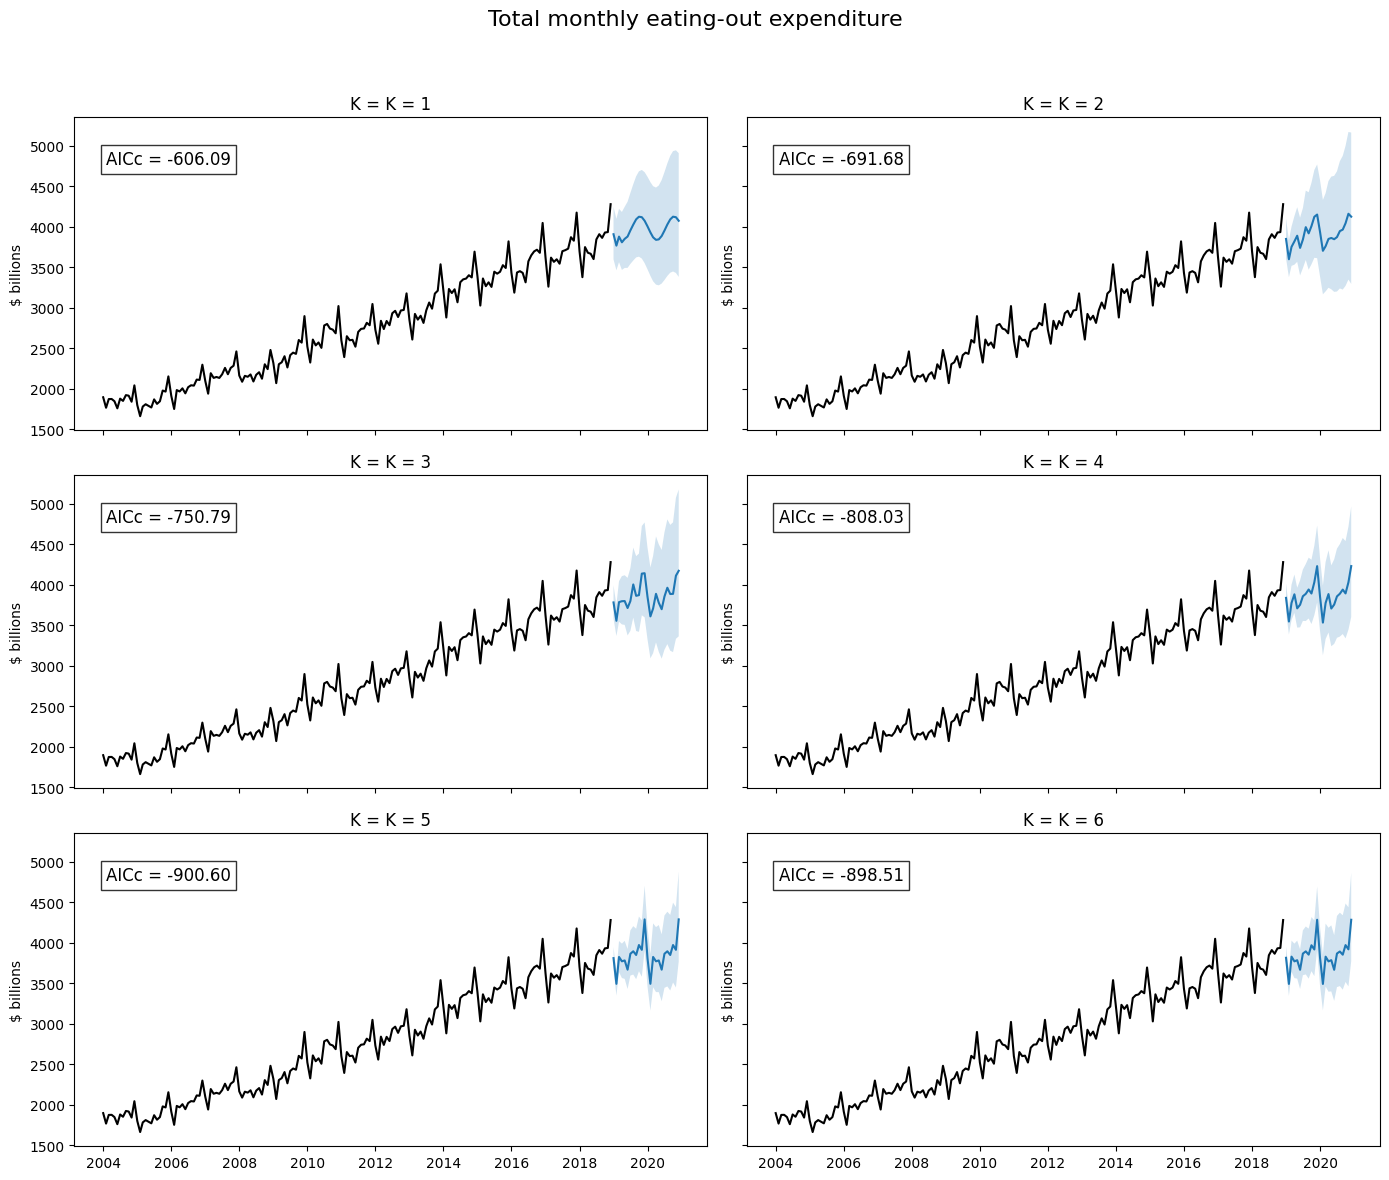

K = 1: AICc = -606.09
K = 2: AICc = -691.68
K = 3: AICc = -750.79
K = 4: AICc = -808.03
K = 5: AICc = -900.60
K = 6: AICc = -898.51


In [51]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt

# Step 1: Load the data
aus_retail = pd.read_csv("sample_data/aus_retail.csv")

# Step 2: Filter the data for "Cafes, restaurants and takeaway food services" from 2004 to 2018
aus_retail['Month'] = pd.to_datetime(aus_retail['Month'], format='%Y %m')
aus_cafe = aus_retail[(aus_retail['Industry'] == "Cafes, restaurants and takeaway food services") &
                      (aus_retail['Month'].dt.year.between(2004, 2018))]

# Step 3: Summarize the data by month and aggregate turnover
monthly_turnover = aus_cafe.groupby(aus_cafe['Month'].dt.to_period('M'))['Turnover'].sum()

# Step 4: Define a function to create Fourier terms for seasonality
def fourier_series(x, K, period):
    n = len(x)
    t = np.arange(1, n + 1)
    results = pd.DataFrame(index=x.index)
    for k in range(1, K + 1):
        results[f'sin_{k}'] = np.sin(2 * np.pi * k * t / period)
        results[f'cos_{k}'] = np.cos(2 * np.pi * k * t / period)
    return results

# Step 5: ARIMA orders for each K value
arima_orders = {
    1: (2, 1, 3),
    2: (5, 1, 1),
    3: (3, 1, 1),
    4: (1, 1, 5),
    5: (2, 1, 0),
    6: (0, 1, 1)
}

# Step 6: Create ARIMA models with Fourier terms (K = 1 to 6)
def fit_arima_with_fourier(K, order):
    # Create Fourier terms for seasonality
    fourier_terms = fourier_series(monthly_turnover, K=K, period=12)

    # Fit ARIMA model with Fourier terms using the specific order for each K
    model = SARIMAX(np.log(monthly_turnover), exog=fourier_terms, order=order, seasonal_order=(0, 0, 0, 12))
    return model.fit()

# Fit ARIMA models for K = 1 to 6 with their specific ARIMA orders
models = {}
forecasts = {}
aiccs = {}

for K in range(1, 7):
    arima_order = arima_orders[K]  # Use the ARIMA order specific to each K
    model = fit_arima_with_fourier(K, arima_order)
    models[f'K = {K}'] = model
    aiccs[f'K = {K}'] = model.aicc

    # Forecast for the next 2 years (24 months)
    future_dates = pd.date_range(monthly_turnover.index[-1].to_timestamp(), periods=24 + 1, freq='M')[1:]
    future_fourier = fourier_series(pd.Series(future_dates), K=K, period=12)
    forecast = model.get_forecast(steps=24, exog=future_fourier)
    forecasts[f'K = {K}'] = forecast

# Step 7: Plot the historical data and forecasts using subplots (facets)
fig, axes = plt.subplots(3, 2, figsize=(14, 12), sharex=True, sharey=True)
axes = axes.flatten()

for i, (K, model) in enumerate(models.items()):
    ax = axes[i]

    # Plot historical data
    ax.plot(monthly_turnover.index.to_timestamp(), monthly_turnover, label='Observed', color='black')

    # Plot forecast (apply np.exp to revert log-transformed forecasts back to original scale)
    forecast_mean = np.exp(forecasts[K].predicted_mean)
    ci = np.exp(forecasts[K].conf_int())  # Apply exp() to confidence intervals too
    ax.plot(forecast_mean.index.to_timestamp(), forecast_mean, label=f'Forecast (K={K})')
    ax.fill_between(forecast_mean.index.to_timestamp(), ci.iloc[:, 0], ci.iloc[:, 1], alpha=0.2)

    # Add AICc to each subplot
    ax.text(0.05, 0.85, f'AICc = {aiccs[K]:.2f}', transform=ax.transAxes, fontsize=12, bbox=dict(facecolor='white', alpha=0.8))
    ax.set_title(f'K = {K}')
    ax.set_ylabel('$ billions')

# Formatting
plt.suptitle('Total monthly eating-out expenditure', fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

# Step 8: Display AICc for each model
for K, aicc in aiccs.items():
    print(f'{K}: AICc = {aicc:.2f}')
